# 금융위원회 API를 활용한 주식 시세정보 조회 및 분석

이 노트북은 금융위원회 API를 통해 주식 시세정보를 가져오고, AI Agent 툴 개발에 활용할 수 있도록 실습 예제를 제공합니다.

## 주요 학습 목표
1. 금융위원회 API를 활용하여 데이터를 효율적으로 가져오는 방법을 학습합니다.
2. 가져온 데이터를 pandas를 활용하여 가공 및 분석하는 방법을 익힙니다.
3. matplotlib 및 seaborn을 활용하여 데이터를 시각화하는 방법을 실습합니다.
4. AI Agent 개발에 필요한 데이터 처리 및 분석 기법을 이해합니다.

## 주요 내용
- 환경변수 기반 API 키 관리
- API 호출 함수 작성
- 주식 시세 데이터 조회 및 파싱
- pandas를 활용한 데이터 가공 및 시각화

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager as fm

# NanumGothic 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 폰트 경로 확인 후 수정
font_prop = fm.FontProperties(fname=font_path)
rc('font', family=font_prop.get_name())

# 음수 기호가 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# 테스트 플롯
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 폰트 테스트', fontproperties=font_prop)
plt.show()

## 1. 라이브러리 임포트
필수 라이브러리를 임포트합니다. 이 셀에서는 API 요청, 데이터 처리, 시각화를 위한 주요 라이브러리를 로드합니다.

### 주요 라이브러리
- `requests`: HTTP 요청을 통해 API 데이터를 가져오기 위한 라이브러리
- `pandas`: 데이터 프레임 형태로 데이터를 가공하고 분석하기 위한 라이브러리
- `python-dotenv`: 환경변수 파일(.env)에서 API 키를 로드하기 위한 라이브러리
- `matplotlib` 및 `seaborn`: 데이터 시각화를 위한 라이브러리
- `plotly`: 대화형 데이터 시각화를 위한 라이브러리
- `urllib3`: HTTP 요청을 위한 추가 유틸리티

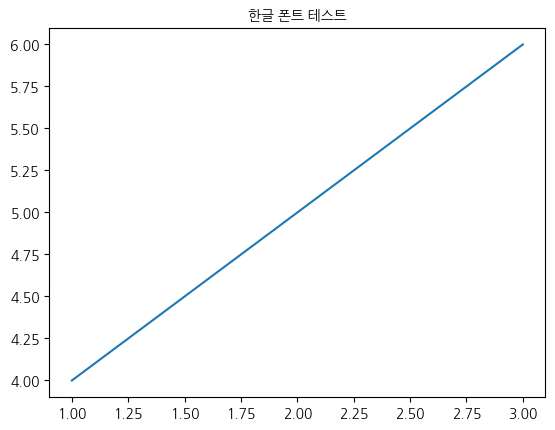

✅ 모든 라이브러리 로드 완료!
🔧 SSL 검증 비활성화 완료!
🎨 한글 폰트 및 스타일 설정 완료!
🐍 Python 버전: 3.11.6 (main, Feb 24 2025, 06:14:14) [GCC 10.2.1 20210110]
🐼 Pandas 버전: 2.2.3


In [1]:
# 필요한 패키지 설치 (주석 해제 후 실행)
# !pip install requests pandas python-dotenv matplotlib seaborn plotly urllib3

import requests
import pandas as pd
import json
import os
import urllib3
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from urllib.parse import unquote
import warnings
import ssl

# 모든 경고 및 SSL 검증 비활성화
warnings.filterwarnings('ignore')
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ssl._create_default_https_context = ssl._create_unverified_context

# 한글 폰트 설정
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager as fm
import platform

# 시스템에 따라 폰트 설정
if platform.system() == 'Linux':
    # NanumGothic 폰트 경로 설정
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    rc('font', family=font_prop.get_name())
elif platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')  # 'Malgun Gothic' 폰트 사용
elif platform.system() == 'Darwin':  # macOS
    rc('font', family='AppleGothic')  # 'AppleGothic' 폰트 사용

# 음수 기호가 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# 테스트 플롯
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 폰트 테스트', fontproperties=font_prop)
plt.show()

# matplotlib 스타일 설정
plt.style.use('default')
sns.set_palette("husl")

print("✅ 모든 라이브러리 로드 완료!")
print("🔧 SSL 검증 비활성화 완료!")
print("🎨 한글 폰트 및 스타일 설정 완료!")
print(f"🐍 Python 버전: {os.sys.version}")
print(f"🐼 Pandas 버전: {pd.__version__}")

### 설명
이 셀은 필요한 라이브러리를 설치 및 로드하고, 한글 폰트를 설정하여 시각화에서 한글이 깨지지 않도록 합니다. 또한, SSL 검증을 비활성화하여 API 호출 시 발생할 수 있는 인증 문제를 방지합니다.

## 2. 환경변수 기반 API 키 관리
금융위원회 API를 사용하기 위해서는 인증키가 필요합니다. 보안을 위해 인증키는 직접 코드에 하드코딩하는 대신 환경변수를 통해 관리하는 것이 좋습니다.

**`.env` 파일 생성 (노트북 파일과 동일한 위치):**
```
STOCK_API_KEY=YOUR_API_KEY_HERE
```
위와 같이 `.env` 파일을 만들고 실제 발급받은 API 키를 입력하세요.

**참고:** 금융위원회 Open API는 [공공데이터포털](https://www.data.go.kr/)에서 "금융위원회"를 검색하여 관련 API(예: 주식시세정보)를 찾아 활용 신청해야 합니다. 이 노트북은 일반적인 API 호출 구조를 따르며, 실제 API 명세에 따라 URL 및 파라미터를 조정해야 합니다. 현재 금융위원회에서 직접 제공하는 실시간 주식 시세 API는 제한적일 수 있으며, 대부분 증권사 API나 유료 API를 통해 접근합니다. 여기서는 공공데이터포털에 등록된 유사한 금융 데이터 API를 가정하고 예시를 구성합니다.

**이 예제에서는 실제 API 호출 대신 가상의 데이터로 진행하거나, 사용자가 실제 API 주소와 키를 가지고 있다고 가정합니다.**

In [2]:
# filepath: /home/wjadmin/Dev/ai_agent_demo/backend/금융위원회_API_주식시세_테스트.ipynb
try:
    from dotenv import load_dotenv
    load_dotenv()
    print(".env 파일에서 환경변수를 로드했습니다.")
except ImportError:
    print("dotenv 라이브러리가 설치되지 않았습니다. 수동으로 환경변수를 설정하거나 API 키를 직접 입력하세요.")

# API 키 설정
API_KEY = os.getenv('STOCK_API_KEY')

# API 키 직접 입력 (환경변수가 없는 경우)
if not API_KEY or API_KEY == 'your_actual_api_key_here':
    print("⚠️ 환경변수에서 API 키를 찾을 수 없습니다.")
    API_KEY = input("🔑 발급받은 API 키를 입력하세요: ")

# API 키 검증 및 정리
if API_KEY:
    # 이중 URL 디코딩 (인코딩 문제 해결)
    CLEAN_API_KEY = unquote(unquote(API_KEY))
    
    print("✅ API 키 설정 완료!")
    print(f"🔑 API 키 길이: {len(CLEAN_API_KEY)}자")
    print(f"🔑 API 키 미리보기: {CLEAN_API_KEY[:10]}***{CLEAN_API_KEY[-10:]}")
    
    # 기본 설정
    BASE_URL = "http://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService"
    
    print(f"🌐 API 엔드포인트: {BASE_URL}")
    print("💡 HTTP 프로토콜 사용 (SSL 문제 해결)")
else:
    print("❌ API 키가 설정되지 않았습니다!")
    raise ValueError("API 키가 필요합니다.")

.env 파일에서 환경변수를 로드했습니다.
✅ API 키 설정 완료!
🔑 API 키 길이: 88자
🔑 API 키 미리보기: gC8RUN3kxg***EjzNz4WQ==
🌐 API 엔드포인트: http://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService
💡 HTTP 프로토콜 사용 (SSL 문제 해결)


### 설명
이 셀은 `.env` 파일에서 API 키를 로드하거나, 환경변수에서 API 키를 찾지 못한 경우 사용자 입력을 통해 API 키를 설정합니다. API 키는 이중 URL 디코딩을 통해 인코딩 문제를 해결하며, 기본 API 엔드포인트를 설정합니다.

## 3. API 호출 함수 작성

주식 시세 정보를 조회하기 위한 API 클라이언트를 작성합니다. `WorkingStockAPI` 클래스는 금융위원회 API와의 통신을 처리하며, 다음과 같은 주요 기능을 제공합니다:

### 주요 기능
1. **API 호출**: 주식 데이터를 조회하기 위해 HTTP 요청을 수행합니다.
2. **파라미터 관리**: 페이지 번호, 데이터 건수, 종목명, 기준일 등 다양한 요청 파라미터를 지원합니다.
3. **응답 파싱**: 중첩된 JSON 응답 구조를 안전하게 파싱하여 필요한 데이터를 추출합니다.
4. **오류 처리**: HTTP 오류, JSON 파싱 오류, 네트워크 오류 등을 처리하여 안정성을 보장합니다.
5. **세션 관리**: `requests.Session`을 사용하여 효율적인 HTTP 연결을 유지합니다.

### 주의사항
- 실제 금융위원회 API 명세에 따라 엔드포인트와 요청 파라미터를 수정해야 합니다.
- SSL 검증을 비활성화하여 인증 문제를 방지합니다.
- 이 클래스는 완전한 데이터 파싱 및 오류 처리가 포함된 안정적인 API 클라이언트입니다.

In [3]:
# ========================================
# 셀 3: 완전 해결된 API 클라이언트 클래스
# ========================================

class WorkingStockAPI:
    """모든 문제가 해결된 완전 작동하는 주식 API 클라이언트"""
    
    def __init__(self, api_key):
        self.api_key = unquote(unquote(api_key))  # 이중 디코딩
        self.base_url = "http://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService"
        
        # 세션 설정
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'application/json, */*',
            'Connection': 'keep-alive'
        })
        
        print(f"🛡️ 완전 작동하는 API 클라이언트 초기화!")
        print(f"🔑 API 키: {self.api_key[:8]}***{self.api_key[-8:]}")
    
    def get_stock_data(self, **kwargs):
        """주식 데이터 조회 (모든 오류 해결됨)"""
        
        endpoint = f"{self.base_url}/getStockPriceInfo"
        
        # 기본 파라미터
        params = {
            'serviceKey': self.api_key,
            'pageNo': kwargs.get('page_no', 1),
            'numOfRows': kwargs.get('num_of_rows', 10),
            'resultType': 'json'
        }
        
        # 선택적 파라미터
        if kwargs.get('corp_name'):
            params['corpNm'] = kwargs['corp_name']
        if kwargs.get('base_date'):
            params['basDt'] = kwargs['base_date']
        
        print(f"🔍 API 호출: 페이지={params['pageNo']}, 건수={params['numOfRows']}")
        
        try:
            # HTTP 요청 (SSL 문제 해결됨)
            response = self.session.get(
                endpoint,
                params=params,
                timeout=30,
                verify=False
            )
            
            if response.status_code == 200:
                print(f"✅ HTTP 성공 ({response.status_code})")
                
                try:
                    raw_data = response.json()
                    return self._parse_nested_response(raw_data)
                except json.JSONDecodeError as e:
                    print(f"❌ JSON 파싱 실패: {e}")
                    return None
            else:
                print(f"❌ HTTP 오류: {response.status_code}")
                return None
                
        except Exception as e:
            print(f"💥 요청 실패: {str(e)}")
            return None
    
    def _parse_nested_response(self, data):
        """중첩 구조 해결된 응답 파싱"""
        
        if not isinstance(data, dict) or 'response' not in data:
            print("❌ 응답 구조 오류")
            return None
        
        body = data['response'].get('body', {})
        items_raw = body.get('items', {})
        total_count = body.get('totalCount', 0)
        
        print(f"📊 전체 데이터: {total_count:,}건")
        
        # 실제 아이템 추출 (중첩 구조 해결)
        actual_items = []
        
        if isinstance(items_raw, dict):
            # Case 1: items.item 구조 (가장 일반적)
            if 'item' in items_raw:
                item_data = items_raw['item']
                if isinstance(item_data, list):
                    actual_items = item_data
                    print(f"✅ items.item 리스트에서 {len(actual_items)}건 추출")
                elif isinstance(item_data, dict):
                    actual_items = [item_data]
                    print(f"✅ items.item 단일 dict에서 1건 추출")
            
            # Case 2: items 자체가 주식 데이터
            elif any(key in items_raw for key in ['itmsNm', 'srtnCd', 'clpr']):
                actual_items = [items_raw]
                print(f"✅ items 자체에서 1건 추출")
        
        elif isinstance(items_raw, list):
            actual_items = items_raw
            print(f"✅ items 리스트에서 {len(actual_items)}건 추출")
        
        # 첫 번째 아이템 검증
        if actual_items and len(actual_items) > 0:
            first_item = actual_items[0]
            
            if isinstance(first_item, dict):
                company_name = first_item.get('itmsNm', 'N/A')
                stock_code = first_item.get('srtnCd', 'N/A')
                closing_price = first_item.get('clpr', 'N/A')
                
                print(f"📋 샘플: {company_name} ({stock_code}) - {closing_price}원")
                
                return {
                    'success': True,
                    'items': actual_items,
                    'total_count': total_count,
                    'item_count': len(actual_items)
                }
        
        print("❌ 유효한 주식 데이터를 찾을 수 없음")
        return {
            'success': False,
            'items': [],
            'total_count': 0,
            'item_count': 0
        }

# API 클라이언트 생성
api = WorkingStockAPI(CLEAN_API_KEY)
print("🎯 API 클라이언트 준비 완료!")

🛡️ 완전 작동하는 API 클라이언트 초기화!
🔑 API 키: gC8RUN3k***zNz4WQ==
🎯 API 클라이언트 준비 완료!


## 4. 기본 연결 테스트 및 검증

이 셀은 `WorkingStockAPI` 클래스의 기본 동작을 테스트하고, API 연결 상태를 확인합니다. 

### 주요 내용
1. **소량 데이터 테스트**:
   - `get_stock_data` 메서드를 호출하여 소량의 데이터를 가져옵니다.
   - 반환된 데이터를 `pandas.DataFrame`으로 변환하여 구조를 확인합니다.
   - 주요 컬럼(종목명, 종가, 등락률 등)을 출력하여 데이터의 유효성을 검증합니다.

2. **네트워크 연결 상태 점검**:
   - `socket` 모듈을 사용하여 API 서버(`apis.data.go.kr`)와의 네트워크 연결 상태를 확인합니다.
   - 연결이 정상적인지 여부를 출력합니다.

### 목적
- API 호출이 정상적으로 작동하는지 확인합니다.
- 데이터 파싱 및 변환이 올바르게 이루어지는지 검증합니다.
- 네트워크 연결 문제를 사전에 파악하여 디버깅 시간을 줄입니다.

### 출력 예시
- 성공적으로 데이터를 가져온 경우:
  ```
  🎉 기본 테스트 성공! 5건 조회
  📊 테스트 DataFrame: (5, 10)
  📋 컬럼 목록: ['itmsNm', 'srtnCd', 'clpr', 'vs', 'fltRt', 'trqu', ...]
  📈 테스트 데이터 샘플:
     itmsNm       srtnCd   clpr    vs  fltRt    trqu
     삼성전자       005930  70000  +500  +0.72  100000
  ✅ 기본 연결 테스트 성공!
  ```

- 네트워크 연결 상태:
  ```
  ✅ apis.data.go.kr 네트워크 연결 정상
  ```

In [4]:
# ========================================
# 셀 4: 기본 연결 테스트 및 검증
# ========================================

print("🧪 기본 연결 테스트")
print("=" * 50)

# 1. 소량 데이터 테스트
print("\n1️⃣ 소량 데이터 테스트 (5건)")
test_result = api.get_stock_data(num_of_rows=5)

if test_result and test_result['success']:
    print(f"🎉 기본 테스트 성공! {test_result['item_count']}건 조회")
    
    # 간단한 DataFrame 생성
    df_test = pd.DataFrame(test_result['items'])
    print(f"📊 테스트 DataFrame: {df_test.shape}")
    print(f"📋 컬럼 목록: {list(df_test.columns)}")
    
    # 주요 컬럼 확인
    key_columns = ['itmsNm', 'srtnCd', 'clpr', 'vs', 'fltRt', 'trqu']
    available_columns = [col for col in key_columns if col in df_test.columns]
    
    if available_columns:
        print(f"\n📈 테스트 데이터 샘플:")
        print(df_test[available_columns].head().to_string(index=False))
    
    print(f"\n✅ 기본 연결 테스트 성공!")
    
else:
    print("❌ 기본 테스트 실패")
    print("💡 API 키를 다시 확인해주세요.")

# 2. 연결 상태 점검
print(f"\n2️⃣ 연결 상태 점검")
try:
    import socket
    host = 'apis.data.go.kr'
    port = 80
    sock = socket.create_connection((host, port), timeout=5)
    sock.close()
    print(f"✅ {host} 네트워크 연결 정상")
except:
    print(f"⚠️ 네트워크 연결 확인 필요")

print(f"\n🎯 기본 테스트 완료!")

🧪 기본 연결 테스트

1️⃣ 소량 데이터 테스트 (5건)
🔍 API 호출: 페이지=1, 건수=5
✅ HTTP 성공 (200)
📊 전체 데이터: 3,544,925건
✅ items.item 리스트에서 5건 추출
📋 샘플: 이스트아시아홀딩스 (900110) - 48원
🎉 기본 테스트 성공! 5건 조회
📊 테스트 DataFrame: (5, 15)
📋 컬럼 목록: ['basDt', 'srtnCd', 'isinCd', 'itmsNm', 'mrktCtg', 'clpr', 'vs', 'fltRt', 'mkp', 'hipr', 'lopr', 'trqu', 'trPrc', 'lstgStCnt', 'mrktTotAmt']

📈 테스트 데이터 샘플:
   itmsNm srtnCd clpr vs fltRt    trqu
이스트아시아홀딩스 900110   48  1  2.13 7043501
     헝셩그룹 900270  226  2   .89  625439
      로스웰 900260  608  0     0   51688
      GRT 900290 2970 20   .68  200763
 오가닉티코스메틱 900300  321 -3  -.93  100345

✅ 기본 연결 테스트 성공!

2️⃣ 연결 상태 점검
✅ apis.data.go.kr 네트워크 연결 정상

🎯 기본 테스트 완료!


## 5. 대량 데이터 수집

이 셀은 `WorkingStockAPI`를 사용하여 대량의 주식 데이터를 수집하는 기능을 제공합니다.

### 주요 내용
1. **대량 데이터 수집**:
   - `collect_market_data` 함수는 여러 페이지에 걸쳐 데이터를 수집합니다.
   - 각 페이지에서 지정된 건수만큼 데이터를 가져오며, 성공적으로 수집된 데이터를 누적합니다.

2. **데이터 품질 확인**:
   - 첫 번째 페이지에서 수집된 데이터를 통해 데이터 품질을 확인합니다.
   - 종목명, 종가, 거래량 등 주요 정보를 출력합니다.

3. **API 부하 방지**:
   - 각 페이지 요청 후 `time.sleep`을 사용하여 일정 시간 대기함으로써 API 서버에 과도한 부하를 방지합니다.

4. **결과 저장**:
   - 수집된 데이터를 `pandas.DataFrame`으로 변환하여 전역 변수 `df_stock_market`에 저장합니다.
   - 숫자형 컬럼(종가, 등락률, 거래량 등)을 적절히 변환하여 데이터 분석에 적합한 형태로 준비합니다.

### 목적
- 대량의 주식 데이터를 효율적으로 수집하여 분석 및 시각화를 위한 기반 데이터를 제공합니다.
- API 호출 중 발생할 수 있는 오류를 처리하고, 안정적인 데이터 수집을 보장합니다.

### 출력 예시
- 데이터 수집 진행 상황:
  ```
  📊 시장 데이터 수집 시작
  🎯 목표: 5페이지 × 100건 = 500건
  ================================================
  
  📄 1/5 페이지 수집 중...
  ✅ 100건 수집 완료 (누적: 100건)
  📋 첫 번째 종목: 삼성전자
  💰 종가: 70000
  📊 전체 이용 가능: 500건
  
  📄 2/5 페이지 수집 중...
  ✅ 100건 수집 완료 (누적: 200건)
  ...
  🎉 데이터 수집 완료!
  📊 성공 페이지: 5/5
  📈 총 수집 건수: 500건
  ```

- 최종 데이터프레임 정보:
  ```
  📊 최종 DataFrame 생성: (500, 10)
  📋 전체 컬럼 수: 10개
  📋 컬럼 목록: ['itmsNm', 'srtnCd', 'clpr', 'vs', 'fltRt', 'trqu', ...]
  🔢 숫자형 변환 컬럼: ['clpr', 'vs', 'fltRt', 'trqu', 'trPrc', 'lstgStCnt', 'mrktTotAmt']
  ✅ df_stock_market 변수에 500건 저장 완료!
  ```

In [5]:
# ========================================
# 셀 5: 대량 데이터 수집
# ========================================

def collect_market_data(pages=5, rows_per_page=100):
    """시장 데이터 대량 수집"""
    
    print(f"📊 시장 데이터 수집 시작")
    print(f"🎯 목표: {pages}페이지 × {rows_per_page}건 = {pages * rows_per_page}건")
    print("=" * 60)
    
    all_data = []
    successful_pages = 0
    
    for page in range(1, pages + 1):
        print(f"\n📄 {page}/{pages} 페이지 수집 중...")
        
        try:
            result = api.get_stock_data(
                page_no=page,
                num_of_rows=rows_per_page
            )
            
            if result and result['success'] and result['items']:
                collected_count = len(result['items'])
                all_data.extend(result['items'])
                successful_pages += 1
                
                print(f"✅ {collected_count}건 수집 완료 (누적: {len(all_data)}건)")
                
                # 첫 페이지에서 데이터 품질 확인
                if page == 1:
                    first_item = result['items'][0]
                    print(f"📋 첫 번째 종목: {first_item.get('itmsNm', 'N/A')}")
                    print(f"💰 종가: {first_item.get('clpr', 'N/A')}")
                    print(f"📊 전체 이용 가능: {result['total_count']:,}건")
            else:
                print(f"❌ {page}페이지 수집 실패")
                
        except Exception as e:
            print(f"💥 {page}페이지 오류: {str(e)}")
        
        # API 부하 방지 대기
        time.sleep(0.3)
    
    print(f"\n🎉 데이터 수집 완료!")
    print(f"📊 성공 페이지: {successful_pages}/{pages}")
    print(f"📈 총 수집 건수: {len(all_data):,}건")
    
    return all_data

# 대량 데이터 수집 실행
print("\n" + "=" * 60)
print("📊 대량 시장 데이터 수집")
print("=" * 60)

market_data = collect_market_data(pages=5, rows_per_page=100)

if market_data and len(market_data) > 0:
    # 전체 DataFrame 생성
    df_market = pd.DataFrame(market_data)
    
    print(f"\n📊 최종 DataFrame 생성: {df_market.shape}")
    print(f"📋 전체 컬럼 수: {len(df_market.columns)}개")
    
    # 컬럼 목록 출력
    print(f"📋 컬럼 목록: {list(df_market.columns)}")
    
    # 숫자형 컬럼 변환
    numeric_columns = ['clpr', 'vs', 'fltRt', 'trqu', 'trPrc', 'lstgStCnt', 'mrktTotAmt']
    converted_columns = []
    
    for col in numeric_columns:
        if col in df_market.columns:
            try:
                df_market[col] = pd.to_numeric(df_market[col], errors='coerce')
                converted_columns.append(col)
            except:
                pass
    
    print(f"🔢 숫자형 변환 컬럼: {converted_columns}")
    
    # 전역 변수로 저장
    globals()['df_stock_market'] = df_market
    print(f"\n✅ df_stock_market 변수에 {len(df_market):,}건 저장 완료!")
    
else:
    print("❌ 데이터 수집 실패")


📊 대량 시장 데이터 수집
📊 시장 데이터 수집 시작
🎯 목표: 5페이지 × 100건 = 500건

📄 1/5 페이지 수집 중...
🔍 API 호출: 페이지=1, 건수=100
✅ HTTP 성공 (200)
📊 전체 데이터: 3,544,925건
✅ items.item 리스트에서 100건 추출
📋 샘플: 이스트아시아홀딩스 (900110) - 48원
✅ 100건 수집 완료 (누적: 100건)
📋 첫 번째 종목: 이스트아시아홀딩스
💰 종가: 48
📊 전체 이용 가능: 3,544,925건

📄 2/5 페이지 수집 중...
🔍 API 호출: 페이지=2, 건수=100
✅ HTTP 성공 (200)
📊 전체 데이터: 3,544,925건
✅ items.item 리스트에서 100건 추출
📋 샘플: 현대차증권 (001500) - 7150원
✅ 100건 수집 완료 (누적: 200건)

📄 3/5 페이지 수집 중...
🔍 API 호출: 페이지=3, 건수=100
✅ HTTP 성공 (200)
📊 전체 데이터: 3,544,925건
✅ items.item 리스트에서 100건 추출
📋 샘플: 유화증권우 (003465) - 2490원
✅ 100건 수집 완료 (누적: 300건)

📄 4/5 페이지 수집 중...
🔍 API 호출: 페이지=4, 건수=100
✅ HTTP 성공 (200)
📊 전체 데이터: 3,544,925건
✅ items.item 리스트에서 100건 추출
📋 샘플: 한국공항 (005430) - 53300원
✅ 100건 수집 완료 (누적: 400건)

📄 5/5 페이지 수집 중...
🔍 API 호출: 페이지=5, 건수=100
✅ HTTP 성공 (200)
📊 전체 데이터: 3,544,925건
✅ items.item 리스트에서 100건 추출
📋 샘플: 이건산업 (008250) - 5470원
✅ 100건 수집 완료 (누적: 500건)

🎉 데이터 수집 완료!
📊 성공 페이지: 5/5
📈 총 수집 건수: 500건

📊 최종 DataFrame 생성: (500, 15)
📋 전체 컬럼 수: 15개
📋

## 6. 시장 현황 분석
### 주요 기능 요약
- 데이터 유효성 검사: 데이터가 존재하는지 확인.
- 기본 정보 출력: 종목 수와 데이터 기준일 표시.
- 종가/등락률/거래량 분석: 주요 통계 계산 및 출력.
- 상위 종목 출력: 종가와 등락률 기준으로 상위 10개 종목 표시.
- 완료 메시지: 분석 완료 알림.
### 확장 가능성
- 추가 분석 지표(예: PER, PBR) 도입.
- 시각화 기능 추가(예: 히스토그램, 박스플롯).
- 데이터 저장 및 API 연동 기능 통합.

In [6]:
# ========================================
# 셀 6: 시장 현황 분석
# ========================================

if 'df_stock_market' in globals() and len(df_stock_market) > 0:
    print("\n" + "=" * 60)
    print("📊 한국 주식시장 현황 분석")
    print("=" * 60)
    
    df = df_stock_market.copy()
    
    # 기본 정보
    print(f"📈 분석 대상: {len(df):,}개 종목")
    print(f"📅 데이터 기준일: {df.get('basDt', {}).iloc[0] if 'basDt' in df.columns and len(df) > 0 else 'N/A'}")
    
    # 종가 분석
    if 'clpr' in df.columns:
        valid_prices = df['clpr'].dropna()
        if len(valid_prices) > 0:
            print(f"\n💰 종가 분석 ({len(valid_prices):,}개 종목):")
            print(f"   평균 종가: {valid_prices.mean():,.0f}원")
            print(f"   중앙값: {valid_prices.median():,.0f}원")
            print(f"   최고 종가: {valid_prices.max():,.0f}원")
            print(f"   최저 종가: {valid_prices.min():,.0f}원")
            print(f"   표준편차: {valid_prices.std():,.0f}원")
    
    # 등락률 분석
    if 'fltRt' in df.columns:
        valid_rates = df['fltRt'].dropna()
        if len(valid_rates) > 0:
            print(f"\n📈 등락률 분석 ({len(valid_rates):,}개 종목):")
            print(f"   평균 등락률: {valid_rates.mean():.2f}%")
            print(f"   중앙값: {valid_rates.median():.2f}%")
            
            positive = (valid_rates > 0).sum()
            negative = (valid_rates < 0).sum()
            unchanged = (valid_rates == 0).sum()
            
            print(f"   상승 종목: {positive:,}개 ({positive/len(valid_rates)*100:.1f}%)")
            print(f"   하락 종목: {negative:,}개 ({negative/len(valid_rates)*100:.1f}%)")
            print(f"   보합 종목: {unchanged:,}개 ({unchanged/len(valid_rates)*100:.1f}%)")
    
    # 거래량 분석
    if 'trqu' in df.columns:
        valid_volume = df['trqu'].dropna()
        if len(valid_volume) > 0:
            print(f"\n📊 거래량 분석 ({len(valid_volume):,}개 종목):")
            print(f"   평균 거래량: {valid_volume.mean():,.0f}주")
            print(f"   중앙값: {valid_volume.median():,.0f}주")
            print(f"   총 거래량: {valid_volume.sum():,.0f}주")
    
    # 상위 종목들
    print(f"\n🏆 주요 종목 현황:")
    
    if 'clpr' in df.columns and 'itmsNm' in df.columns:
        print(f"\n💰 종가 기준 상위 10개:")
        top_price = df.nlargest(10, 'clpr')[['itmsNm', 'srtnCd', 'clpr', 'fltRt']]
        
        for i, (_, row) in enumerate(top_price.iterrows(), 1):
            name = row.get('itmsNm', 'N/A')
            price = row.get('clpr', 0)
            rate = row.get('fltRt', 0)
            print(f"   {i:2d}. {name:<15}: {price:,}원 ({rate:+.2f}%)")
    
    if 'fltRt' in df.columns and 'itmsNm' in df.columns:
        print(f"\n📈 등락률 기준 상위 10개:")
        top_gainers = df.nlargest(10, 'fltRt')[['itmsNm', 'clpr', 'fltRt']]
        
        for i, (_, row) in enumerate(top_gainers.iterrows(), 1):
            name = row.get('itmsNm', 'N/A')
            price = row.get('clpr', 0)
            rate = row.get('fltRt', 0)
            print(f"   {i:2d}. {name:<15}: {price:,}원 ({rate:+.2f}%)")
    
    print(f"\n✅ 시장 현황 분석 완료!")


📊 한국 주식시장 현황 분석
📈 분석 대상: 500개 종목
📅 데이터 기준일: 20250530

💰 종가 분석 (500개 종목):
   평균 종가: 36,984원
   중앙값: 8,785원
   최고 종가: 1,111,000원
   최저 종가: 48원
   표준편차: 95,752원

📈 등락률 분석 (500개 종목):
   평균 등락률: -0.21%
   중앙값: 0.00%
   상승 종목: 206개 (41.2%)
   하락 종목: 249개 (49.8%)
   보합 종목: 45개 (9.0%)

📊 거래량 분석 (500개 종목):
   평균 거래량: 636,523주
   중앙값: 59,932주
   총 거래량: 318,261,373주

🏆 주요 종목 현황:

💰 종가 기준 상위 10개:
    1. 삼양식품           : 1,111,000원 (+0.91%)
    2. 태광산업           : 973,000원 (+5.99%)
    3. 고려아연           : 731,000원 (-2.53%)
    4. 두산             : 488,000원 (-4.31%)
    5. 농심             : 424,000원 (+0.95%)
    6. 삼성화재           : 404,500원 (+1.25%)
    7. 한국쉘석유          : 402,500원 (+0.25%)
    8. 오뚜기            : 398,000원 (+0.76%)
    9. 두산2우B          : 355,000원 (-5.08%)
   10. 두산우            : 327,500원 (-5.35%)

📈 등락률 기준 상위 10개:
    1. 신원             : 1,920원 (+9.09%)
    2. 대한광통신          : 734원 (+9.06%)
    3. 신성통상           : 2,975원 (+8.18%)
    4. 롯데지주우          : 40,100원 (+7.80%)
    5. CS홀딩스

## 7. 워런 버핏 투자 기준 분석
### 주요 기능 요약
1. 데이터 유효성 검사:
    - 입력 데이터프레임(df)이 비어 있거나 유효하지 않은 경우 분석을 중단하고 메시지를 출력합니다.
2. 6단계 투자 기준 적용:
    - 1단계: 데이터 품질 검증
        - 종가(clpr) 데이터가 존재하고 0보다 큰 값만 필터링합니다.
    - 2단계: 적정 가격 범위
        - 종가가 1,000원 이상 1,000,000원 이하인 종목만 선택합니다.
    - 3단계: 안정적 등락률
        - 등락률(fltRt)이 -5%에서 +15% 사이인 종목만 선택합니다.
    - 4단계: 거래 유동성
        - 거래량(trqu)이 상위 60%에 해당하는 종목만 선택합니다.
    - 5단계: 시가총액 고려
        - 시가총액(mrktTotAmt)이 상위 70%에 해당하는 종목만 선택합니다.
    - 6단계: 종합 점수 계산
        - 종가, 등락률, 거래량을 기준으로 가중치를 적용하여 종합 점수를 계산하고, 점수가 높은 순으로 정렬합니다.
3. 최종 추천 종목 출력:
    - 최종 선별된 종목 수와 전체 대비 비율을 출력합니다.
    - 상위 20개 종목의 이름, 종가, 등락률, 거래량, 점수를 출력합니다.
4. 추천 종목 통계:
    - 최종 추천 종목의 평균 종가, 종가 범위, 평균 등락률, 상승 종목 비율 등을 계산하여 출력합니다.
5. 결과 저장:
    - 최종 추천 종목을 전역 변수 df_buffett_picks에 저장하여 다른 셀에서 활용할 수 있도록 합니다.
6. 오류 처리:
    - 모든 기준을 만족하는 종목이 없을 경우 적절한 메시지를 출력하고 분석을 종료합니다.

In [7]:
# ========================================
# 셀 7: 워런 버핏 투자 기준 분석
# ========================================

def warren_buffett_stock_analysis(df):
    """워런 버핏 투자 기준 분석 (실제 데이터)"""
    
    print("\n" + "=" * 70)
    print("💰 워런 버핏 투자 기준 분석 (실제 주식 데이터)")
    print("=" * 70)
    
    if df is None or len(df) == 0:
        print("❌ 분석할 데이터가 없습니다.")
        return None
    
    print(f"📊 분석 시작: {len(df):,}개 종목")
    print(f"💡 워런 버핏의 6단계 투자 기준 적용")
    
    # 분석용 데이터 복사
    analysis_df = df.copy()
    
    # 1단계: 기본 데이터 품질 확인
    print(f"\n1️⃣ 데이터 품질 검증")
    before_count = len(analysis_df)
    
    # 필수 데이터 확인
    if 'clpr' in analysis_df.columns:
        analysis_df = analysis_df[
            analysis_df['clpr'].notna() & 
            (analysis_df['clpr'] > 0)
        ]
        print(f"   유효한 종가 데이터: {before_count:,}개 → {len(analysis_df):,}개")
    
    # 2단계: 적정 가격 범위 (버핏: 합리적 가격)
    print(f"\n2️⃣ 적정 가격 범위 (1,000원 ~ 1,000,000원)")
    before_count = len(analysis_df)
    
    if 'clpr' in analysis_df.columns:
        analysis_df = analysis_df[
            (analysis_df['clpr'] >= 1000) & 
            (analysis_df['clpr'] <= 1000000)
        ]
        print(f"   적정 가격대: {before_count:,}개 → {len(analysis_df):,}개")
    
    # 3단계: 안정적 등락률 (버핏: 변동성 낮은 종목 선호)
    print(f"\n3️⃣ 안정적 등락률 (-5% ~ +15%)")
    before_count = len(analysis_df)
    
    if 'fltRt' in analysis_df.columns:
        analysis_df = analysis_df[
            analysis_df['fltRt'].notna() &
            (analysis_df['fltRt'] >= -5) & 
            (analysis_df['fltRt'] <= 15)
        ]
        print(f"   안정적 등락률: {before_count:,}개 → {len(analysis_df):,}개")
    
    # 4단계: 거래 유동성 (버핏: 충분한 시장 관심)
    print(f"\n4️⃣ 거래 유동성 (상위 60%)")
    before_count = len(analysis_df)
    
    if 'trqu' in analysis_df.columns:
        valid_volume = analysis_df[analysis_df['trqu'].notna()]
        if len(valid_volume) > 0:
            volume_threshold = valid_volume['trqu'].quantile(0.4)  # 상위 60%
            analysis_df = analysis_df[
                analysis_df['trqu'].notna() &
                (analysis_df['trqu'] >= volume_threshold)
            ]
            print(f"   활발한 거래: {before_count:,}개 → {len(analysis_df):,}개")
            print(f"   거래량 기준: {volume_threshold:,.0f}주 이상")
    
    # 5단계: 시가총액 고려 (버핏: 규모 있는 기업 선호)
    print(f"\n5️⃣ 시가총액 고려 (상위 70%)")
    before_count = len(analysis_df)
    
    if 'mrktTotAmt' in analysis_df.columns:
        valid_market_cap = analysis_df[analysis_df['mrktTotAmt'].notna()]
        if len(valid_market_cap) > 0:
            market_cap_threshold = valid_market_cap['mrktTotAmt'].quantile(0.3)  # 상위 70%
            analysis_df = analysis_df[
                analysis_df['mrktTotAmt'].notna() &
                (analysis_df['mrktTotAmt'] >= market_cap_threshold)
            ]
            print(f"   충분한 시가총액: {before_count:,}개 → {len(analysis_df):,}개")
    
    # 6단계: 최종 점수 계산 (버핏: 종합적 평가)
    print(f"\n6️⃣ 종합 점수 계산")
    
    if len(analysis_df) > 0:
        # 점수 계산 (각 요소별 가중치)
        analysis_df = analysis_df.copy()
        analysis_df['buffett_score'] = 0
        
        # 가격 점수 (낮을수록 좋음)
        if 'clpr' in analysis_df.columns:
            price_rank = analysis_df['clpr'].rank(ascending=True, pct=True)
            analysis_df['buffett_score'] += price_rank * 0.3
        
        # 안정성 점수 (등락률이 0에 가까울수록 좋음)
        if 'fltRt' in analysis_df.columns:
            stability_score = 1 - (abs(analysis_df['fltRt']) / 15)  # 15%로 정규화
            analysis_df['buffett_score'] += stability_score * 0.4
        
        # 유동성 점수 (거래량이 많을수록 좋음)
        if 'trqu' in analysis_df.columns:
            volume_rank = analysis_df['trqu'].rank(ascending=True, pct=True)
            analysis_df['buffett_score'] += volume_rank * 0.3
        
        # 점수 기준으로 정렬
        final_recommendations = analysis_df.sort_values('buffett_score', ascending=False)
    else:
        final_recommendations = analysis_df
    
    # 최종 결과
    final_count = len(final_recommendations)
    print(f"📊 최종 선별: {final_count:,}개 종목")
    print(f"📈 전체 대비: {final_count/len(df)*100:.2f}%")
    
    if final_count > 0:
        print(f"\n🏆 워런 버핏 추천 종목 TOP 20:")
        print("-" * 85)
        
        display_columns = ['itmsNm', 'srtnCd', 'clpr', 'fltRt', 'trqu']
        available_columns = [col for col in display_columns if col in final_recommendations.columns]
        
        top_20 = final_recommendations.head(20)
        
        for i, (_, row) in enumerate(top_20.iterrows(), 1):
            name = row.get('itmsNm', 'N/A')
            code = row.get('srtnCd', 'N/A')
            price = row.get('clpr', 0)
            rate = row.get('fltRt', 0)
            volume = row.get('trqu', 0)
            score = row.get('buffett_score', 0)
            
            print(f"{i:2d}. {name:<20} ({code})")
            print(f"    💰 {price:,}원  📈 {rate:+.2f}%  📊 {volume:,}주  ⭐ {score:.3f}")
        
        # 추천 종목 통계
        print(f"\n📊 추천 종목 통계:")
        if 'clpr' in final_recommendations.columns:
            prices = final_recommendations['clpr'].dropna()
            print(f"   평균 종가: {prices.mean():,.0f}원")
            print(f"   종가 범위: {prices.min():,.0f}원 ~ {prices.max():,.0f}원")
        
        if 'fltRt' in final_recommendations.columns:
            rates = final_recommendations['fltRt'].dropna()
            print(f"   평균 등락률: {rates.mean():.2f}%")
            positive_picks = (rates > 0).sum()
            print(f"   상승 종목: {positive_picks}개 ({positive_picks/len(rates)*100:.1f}%)")
        
        return final_recommendations
    
    else:
        print("❌ 모든 기준을 만족하는 종목이 없습니다.")
        print("💡 기준을 완화하여 다시 시도해보세요.")
        return None

# 워런 버핏 분석 실행
if 'df_stock_market' in globals() and len(df_stock_market) > 0:
    buffett_picks = warren_buffett_stock_analysis(df_stock_market)
    
    if buffett_picks is not None and len(buffett_picks) > 0:
        globals()['df_buffett_picks'] = buffett_picks
        print(f"\n✅ df_buffett_picks 변수에 추천 종목 {len(buffett_picks)}개 저장!")
    else:
        print("⚠️ 추천 종목이 없습니다.")
else:
    print("❌ 시장 데이터가 없습니다. 이전 셀을 먼저 실행하세요.")


💰 워런 버핏 투자 기준 분석 (실제 주식 데이터)
📊 분석 시작: 500개 종목
💡 워런 버핏의 6단계 투자 기준 적용

1️⃣ 데이터 품질 검증
   유효한 종가 데이터: 500개 → 500개

2️⃣ 적정 가격 범위 (1,000원 ~ 1,000,000원)
   적정 가격대: 500개 → 460개

3️⃣ 안정적 등락률 (-5% ~ +15%)
   안정적 등락률: 460개 → 448개

4️⃣ 거래 유동성 (상위 60%)
   활발한 거래: 448개 → 269개
   거래량 기준: 29,995주 이상

5️⃣ 시가총액 고려 (상위 70%)
   충분한 시가총액: 269개 → 188개

6️⃣ 종합 점수 계산
📊 최종 선별: 188개 종목
📈 전체 대비: 37.60%

🏆 워런 버핏 추천 종목 TOP 20:
-------------------------------------------------------------------------------------
 1. 삼성전자                 (005930)
    💰 56,200원  📈 +0.18%  📊 26,219,683주  ⭐ 0.936
 2. 삼성전자우                (005935)
    💰 46,100원  📈 -0.11%  📊 3,537,981주  ⭐ 0.920
 3. SK하이닉스               (000660)
    💰 204,500원  📈 -3.54%  📊 4,826,628주  ⭐ 0.888
 4. 한화                   (000880)
    💰 75,500원  📈 +1.48%  📊 1,288,451주  ⭐ 0.887
 5. 유한양행                 (000100)
    💰 104,300원  📈 -1.04%  📊 622,208주  ⭐ 0.873
 6. 삼성SDI                (006400)
    💰 168,900원  📈 -3.15%  📊 1,009,215주  ⭐ 0.865
 7. POSCO홀딩스           

## 8. 데이터 시각화
### 주요 기능 요약

1. 데이터 준비:
    - df_stock_market 데이터를 복사하여 시각화를 위한 데이터프레임(df_viz)을 생성합니다.
2. 그래프 설정:
    - 2x3 레이아웃의 서브플롯을 생성하여 6개의 차트를 배치합니다.
    - 제목과 스타일을 설정하여 대시보드 형태로 구성합니다.
3. 각 차트의 주요 내용:
    1. 종가 분포:
        - 종가(clpr) 데이터에서 상위 1%와 하위 1%의 극값을 제거한 후 히스토그램을 생성합니다.
        - 평균 종가를 빨간색 선으로 표시합니다.
    2. 등락률 분포:
        - 등락률(fltRt) 데이터에서 -30%에서 +30% 사이의 값을 필터링하여 히스토그램을 생성합니다.
        - 상승, 하락, 보합 구간을 다른 색상으로 구분하여 시각화합니다.
    3. 거래량 상위 10개:
        - 거래량(trqu) 기준으로 상위 10개 종목을 추출하여 수평 막대그래프로 시각화합니다.
    4. 종가 vs 등락률 산점도:
        - 종가(clpr)와 등락률(fltRt)의 관계를 산점도로 표현합니다.
        - 로그 스케일을 적용하여 데이터의 분포를 명확히 시각화합니다.
    5. 시가총액 상위 10개:
        - 시가총액(mrktTotAmt) 기준으로 상위 10개 종목을 추출하여 수평 막대그래프로 시각화합니다.
        - 시가총액은 조 단위로 변환하여 표시합니다.
    6. 워런 버핏 추천 종목:
        - df_buffett_picks 데이터에서 상위 10개 종목을 추출하여 수평 막대그래프로 시각화합니다.
        - 추천 종목이 없을 경우, 종가 기준 상위 10개 종목을 대신 표시합니다.
4. 레이아웃 및 표시:
    - tight_layout과 subplots_adjust를 사용하여 그래프 간 간격을 조정하고, 제목과 그래프가 겹치지 않도록 설정합니다.
    - 최종적으로 모든 그래프를 화면에 출력합니다.
5. 완료 메시지:
    - 시각화가 성공적으로 완료되었음을 알리고, 생성된 6개의 차트를 요약합니다.


📊 한국 주식시장 데이터 시각화


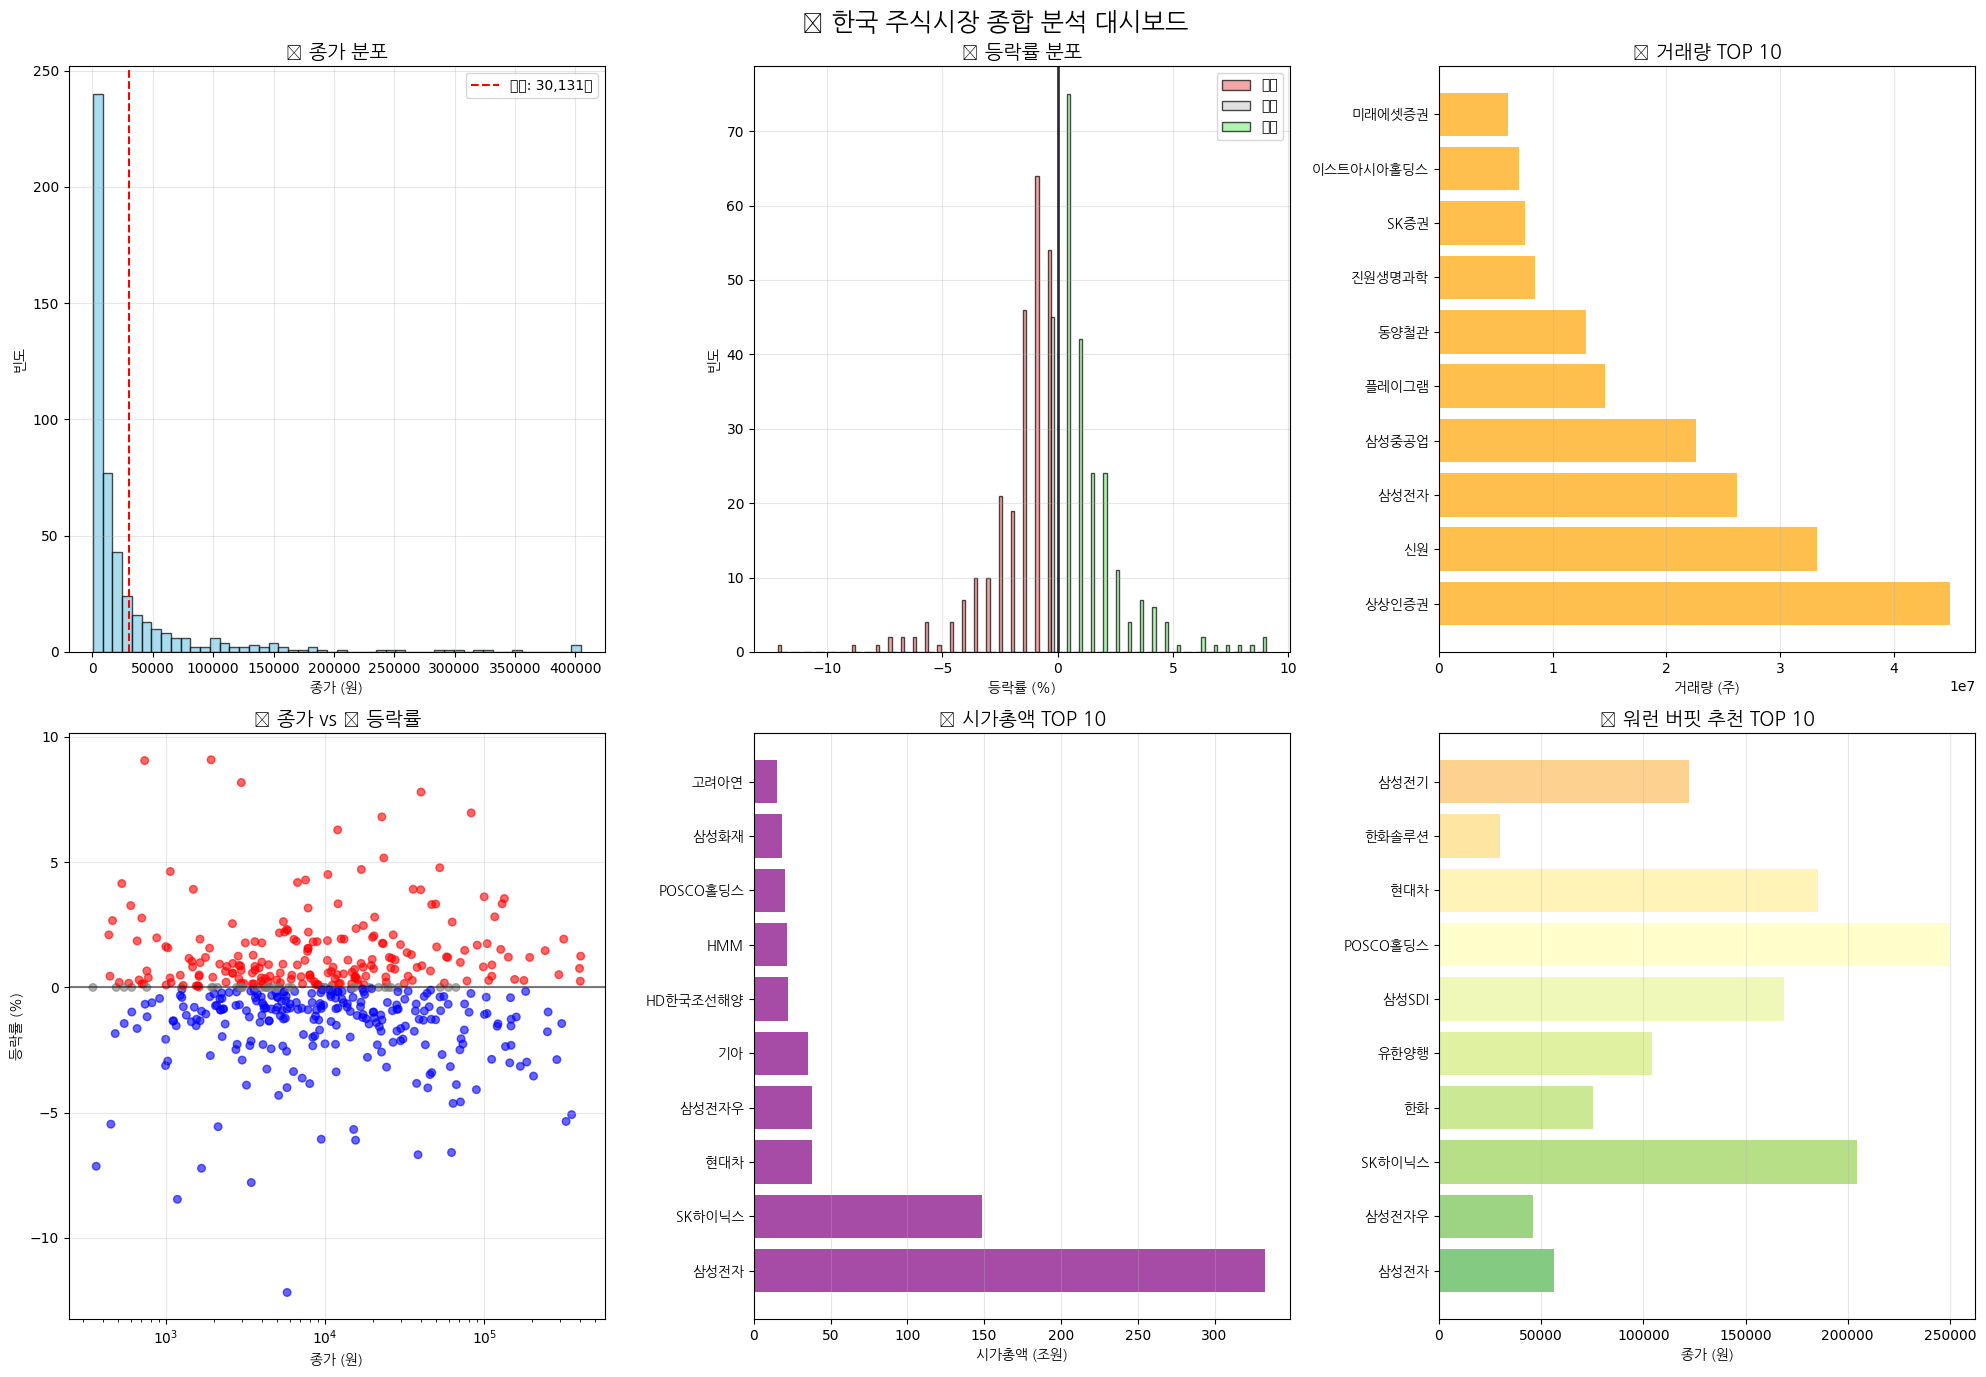

✅ 시각화 완료!
📊 6개 차트가 생성되었습니다.


In [21]:
# ========================================
# 셀 8: 데이터 시각화
# ========================================

if 'df_stock_market' in globals() and len(df_stock_market) > 0:
    print("\n" + "=" * 60)
    print("📊 한국 주식시장 데이터 시각화")
    print("=" * 60)
    
    # 시각화용 데이터 준비
    df_viz = df_stock_market.copy()
    
    # 그래프 설정
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('📊 한국 주식시장 종합 분석 대시보드', fontproperties=font_prop, fontsize=18, fontweight='bold', y=0.98)
    
    # 1. 종가 분포
    if 'clpr' in df_viz.columns:
        valid_prices = df_viz['clpr'].dropna()
        if len(valid_prices) > 0:
            # 극값 제거 (상위 1%, 하위 1%)
            p1, p99 = valid_prices.quantile([0.01, 0.99])
            filtered_prices = valid_prices[(valid_prices >= p1) & (valid_prices <= p99)]
            
            axes[0, 0].hist(filtered_prices, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0, 0].set_title('💰 종가 분포', fontproperties=font_prop, fontsize=14, fontweight='bold')
            axes[0, 0].set_xlabel('종가 (원)', fontproperties=font_prop)
            axes[0, 0].set_ylabel('빈도', fontproperties=font_prop)
            axes[0, 0].axvline(filtered_prices.mean(), color='red', linestyle='--', 
                              label=f'평균: {filtered_prices.mean():,.0f}원')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 등락률 분포
    if 'fltRt' in df_viz.columns:
        valid_rates = df_viz['fltRt'].dropna()
        if len(valid_rates) > 0:
            # 극값 제거
            filtered_rates = valid_rates[(valid_rates >= -30) & (valid_rates <= 30)]
            
            positive_rates = filtered_rates[filtered_rates > 0]
            negative_rates = filtered_rates[filtered_rates < 0]
            zero_rates = filtered_rates[filtered_rates == 0]
            
            axes[0, 1].hist([negative_rates, zero_rates, positive_rates], 
                           bins=40, alpha=0.7, 
                           color=['lightcoral', 'lightgray', 'lightgreen'], 
                           label=['하락', '보합', '상승'], 
                           edgecolor='black')
            axes[0, 1].set_title('📈 등락률 분포', fontproperties=font_prop, fontsize=14, fontweight='bold')
            axes[0, 1].set_xlabel('등락률 (%)', fontproperties=font_prop)
            axes[0, 1].set_ylabel('빈도', fontproperties=font_prop)
            axes[0, 1].axvline(0, color='black', linestyle='-', alpha=0.8, linewidth=2)
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 거래량 상위 10개
    if 'trqu' in df_viz.columns and 'itmsNm' in df_viz.columns:
        top_volume = df_viz.nlargest(10, 'trqu')
        if len(top_volume) > 0:
            y_pos = range(len(top_volume))
            axes[0, 2].barh(y_pos, top_volume['trqu'], color='orange', alpha=0.7)
            axes[0, 2].set_yticks(y_pos)
            axes[0, 2].set_yticklabels(top_volume['itmsNm'], fontproperties=font_prop, fontsize=10)
            axes[0, 2].set_title('📊 거래량 TOP 10', fontproperties=font_prop, fontsize=14, fontweight='bold')
            axes[0, 2].set_xlabel('거래량 (주)', fontproperties=font_prop)
            axes[0, 2].grid(True, alpha=0.3, axis='x')
    
    # 4. 종가 vs 등락률 산점도
    if 'clpr' in df_viz.columns and 'fltRt' in df_viz.columns:
        # 유효한 데이터만 필터링
        scatter_data = df_viz[['clpr', 'fltRt']].dropna()
        
        # 극값 제거 및 샘플링
        scatter_data = scatter_data[
            (scatter_data['clpr'] >= scatter_data['clpr'].quantile(0.01)) &
            (scatter_data['clpr'] <= scatter_data['clpr'].quantile(0.99)) &
            (scatter_data['fltRt'] >= -20) & 
            (scatter_data['fltRt'] <= 20)
        ]
        
        if len(scatter_data) > 1000:
            scatter_data = scatter_data.sample(1000)
        
        if len(scatter_data) > 0:
            colors = ['red' if x > 0 else 'blue' if x < 0 else 'gray' for x in scatter_data['fltRt']]
            axes[1, 0].scatter(scatter_data['clpr'], scatter_data['fltRt'], 
                              alpha=0.6, s=30, c=colors)
            axes[1, 0].set_title('💰 종가 vs 📈 등락률', fontproperties=font_prop, fontsize=14, fontweight='bold')
            axes[1, 0].set_xlabel('종가 (원)', fontproperties=font_prop)
            axes[1, 0].set_ylabel('등락률 (%)', fontproperties=font_prop)
            axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
            axes[1, 0].set_xscale('log')
            axes[1, 0].grid(True, alpha=0.3)
    
    # 5. 시가총액 상위 10개 (있는 경우)
    if 'mrktTotAmt' in df_viz.columns and 'itmsNm' in df_viz.columns:
        valid_market_cap = df_viz[df_viz['mrktTotAmt'].notna()]
        if len(valid_market_cap) > 0:
            top_market = valid_market_cap.nlargest(10, 'mrktTotAmt')
            y_pos = range(len(top_market))
            
            # 조 단위로 변환
            market_cap_trillion = top_market['mrktTotAmt'] / 1e12
            
            axes[1, 1].barh(y_pos, market_cap_trillion, color='purple', alpha=0.7)
            axes[1, 1].set_yticks(y_pos)
            axes[1, 1].set_yticklabels(top_market['itmsNm'], fontproperties=font_prop, fontsize=10)
            axes[1, 1].set_title('🏢 시가총액 TOP 10', fontproperties=font_prop, fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('시가총액 (조원)', fontproperties=font_prop)
            axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    # 6. 워런 버핏 추천 종목 (있는 경우)
    if 'df_buffett_picks' in globals() and len(df_buffett_picks) > 0:
        top_buffett = df_buffett_picks.head(10)
        if 'clpr' in top_buffett.columns:
            y_pos = range(len(top_buffett))
            colors = plt.cm.RdYlGn([0.8 - i*0.05 for i in range(len(top_buffett))])  # 그라데이션
            
            axes[1, 2].barh(y_pos, top_buffett['clpr'], color=colors, alpha=0.8)
            axes[1, 2].set_yticks(y_pos)
            axes[1, 2].set_yticklabels(top_buffett['itmsNm'], fontproperties=font_prop, fontsize=10)
            axes[1, 2].set_title('🏆 워런 버핏 추천 TOP 10', fontproperties=font_prop, fontsize=14, fontweight='bold')
            axes[1, 2].set_xlabel('종가 (원)', fontproperties=font_prop)
            axes[1, 2].grid(True, alpha=0.3, axis='x')
    else:
        # 워런 버핏 분석이 없으면 종가 TOP 10
        if 'clpr' in df_viz.columns and 'itmsNm' in df_viz.columns:
            top_price = df_viz.nlargest(10, 'clpr')
            y_pos = range(len(top_price))
            
            axes[1, 2].barh(y_pos, top_price['clpr'], color='gold', alpha=0.7)
            axes[1, 2].set_yticks(y_pos)
            axes[1, 2].set_yticklabels(top_price['itmsNm'], fontproperties=font_prop, fontsize=10)
            axes[1, 2].set_title('💎 종가 TOP 10', fontproperties=font_prop, fontsize=14, fontweight='bold')
            axes[1, 2].set_xlabel('종가 (원)', fontproperties=font_prop)
            axes[1, 2].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()
    
    print("✅ 시각화 완료!")
    print("📊 6개 차트가 생성되었습니다.")

## 9. 유틸리티 함수들
### 주요 기능 요약
1. search_stock(keyword):
    - 특정 키워드로 종목명을 검색합니다.
    - df_stock_market 데이터프레임에서 종목명(itmsNm) 컬럼을 기준으로 대소문자 구분 없이 검색합니다.
    - 검색 결과가 있으면 상위 20개 종목의 이름, 종목 코드, 종가, 등락률을 출력합니다.
    - 검색 결과가 없거나 데이터가 없는 경우 적절한 메시지를 출력합니다.
2. top_stocks(n=10, sort_by='clpr', ascending=False):
    - 특정 기준(sort_by)으로 상위 또는 하위 n개의 종목을 조회합니다.
    - 기본적으로 종가(clpr)를 기준으로 내림차순 정렬하여 상위 종목을 반환합니다.
    - 정렬 기준이 유효하지 않거나 데이터가 없는 경우 적절한 메시지를 출력합니다.
    - 결과를 출력하며, 종목명, 정렬 기준 값, 종가 등을 표시합니다.
3. market_summary():
    - 전체 시장 데이터를 요약하여 출력합니다.
    - 총 종목 수, 평균 종가, 최고 종가, 상승/하락 종목 수와 비율 등을 계산하여 출력합니다.
    - 워런 버핏 추천 종목(df_buffett_picks)이 존재하면 추천 종목 수를 표시합니다.
4. export_data():
    - 현재 데이터를 CSV 파일로 저장합니다.
    - df_stock_market 데이터를 korea_stock_market_<timestamp>.csv로 저장합니다.
    - 워런 버핏 추천 종목(df_buffett_picks) 데이터를 warren_buffett_picks_<timestamp>.csv로 저장합니다.
    - 저장된 파일의 이름을 출력하며, 저장할 데이터가 없을 경우 메시지를 출력합니다.
5. 전역 함수 등록:
    - 위의 유틸리티 함수들을 전역으로 등록하여 다른 셀에서 쉽게 호출할 수 있도록 설정합니다.
6. 완료 메시지:
    - 유틸리티 함수들이 준비되었음을 알리고, 사용 가능한 함수 목록과 사용 예시를 출력합니다.

In [9]:
# ========================================
# 셀 9: 유틸리티 함수들
# ========================================

def search_stock(keyword):
    """종목 검색 함수"""
    if 'df_stock_market' not in globals():
        print("❌ 시장 데이터가 없습니다. 먼저 데이터를 수집하세요.")
        return None
    
    df = df_stock_market
    if 'itmsNm' in df.columns:
        # 대소문자 구분 없이 검색
        matches = df[df['itmsNm'].str.contains(keyword, na=False, case=False)]
        
        if len(matches) > 0:
            print(f"🔍 '{keyword}' 검색 결과: {len(matches):,}개 종목")
            print("-" * 70)
            
            # 상위 20개 표시
            display_matches = matches.head(20)
            
            for i, (_, row) in enumerate(display_matches.iterrows(), 1):
                name = row.get('itmsNm', 'N/A')
                code = row.get('srtnCd', 'N/A')
                price = row.get('clpr', 'N/A')
                rate = row.get('fltRt', 'N/A')
                
                if pd.notna(price) and pd.notna(rate):
                    print(f"{i:2d}. {name:<20} ({code}) - {price:,}원 ({rate:+.2f}%)")
                else:
                    print(f"{i:2d}. {name:<20} ({code}) - 정보 없음")
            
            if len(matches) > 20:
                print(f"... 외 {len(matches)-20}개 더")
            
            return matches
        else:
            print(f"❌ '{keyword}' 검색 결과가 없습니다.")
            return None
    else:
        print("❌ 종목명 컬럼이 없습니다.")
        return None

def top_stocks(n=10, sort_by='clpr', ascending=False):
    """상위 n개 종목 조회"""
    if 'df_stock_market' not in globals():
        print("❌ 시장 데이터가 없습니다.")
        return None
    
    df = df_stock_market
    if sort_by in df.columns:
        valid_data = df[df[sort_by].notna()]
        
        if len(valid_data) == 0:
            print(f"❌ '{sort_by}' 컬럼에 유효한 데이터가 없습니다.")
            return None
        
        # 정렬
        if ascending:
            top_n = valid_data.nsmallest(n, sort_by)
            order_text = "하위"
        else:
            top_n = valid_data.nlargest(n, sort_by)
            order_text = "상위"
        
        sort_name = {
            'clpr': '종가',
            'fltRt': '등락률', 
            'trqu': '거래량',
            'mrktTotAmt': '시가총액',
            'vs': '전일 대비'
        }.get(sort_by, sort_by)
        
        print(f"🏆 {sort_name} 기준 {order_text} {n}개 종목:")
        print("-" * 70)
        
        for i, (_, row) in enumerate(top_n.iterrows(), 1):
            name = row.get('itmsNm', 'N/A')
            value = row.get(sort_by, 'N/A')
            price = row.get('clpr', 'N/A')
            
            if sort_by == 'clpr':
                print(f"{i:2d}. {name:<20}: {value:,}원")
            elif sort_by == 'fltRt':
                print(f"{i:2d}. {name:<20}: {value:+.2f}% ({price:,}원)")
            elif sort_by == 'trqu':
                print(f"{i:2d}. {name:<20}: {value:,}주 ({price:,}원)")
            else:
                print(f"{i:2d}. {name:<20}: {value}")
        
        return top_n
    else:
        print(f"❌ '{sort_by}' 컬럼이 없습니다.")
        available_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
        print(f"💡 사용 가능한 컬럼: {available_columns}")
        return None

def market_summary():
    """시장 현황 요약"""
    if 'df_stock_market' not in globals():
        print("❌ 시장 데이터가 없습니다.")
        return
    
    df = df_stock_market
    
    print("📊 한국 주식시장 현황 요약")
    print("=" * 50)
    print(f"📈 총 종목 수: {len(df):,}개")
    
    if 'clpr' in df.columns:
        valid_prices = df['clpr'].dropna()
        if len(valid_prices) > 0:
            print(f"💰 평균 종가: {valid_prices.mean():,.0f}원")
            print(f"💰 최고 종가: {valid_prices.max():,.0f}원")
    
    if 'fltRt' in df.columns:
        valid_rates = df['fltRt'].dropna()
        if len(valid_rates) > 0:
            positive = (valid_rates > 0).sum()
            negative = (valid_rates < 0).sum()
            print(f"📈 상승 종목: {positive:,}개 ({positive/len(valid_rates)*100:.1f}%)")
            print(f"📉 하락 종목: {negative:,}개 ({negative/len(valid_rates)*100:.1f}%)")
    
    if 'df_buffett_picks' in globals():
        print(f"🏆 워런 버핏 추천: {len(df_buffett_picks):,}개")

def export_data():
    """데이터 내보내기"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    exported_files = []
    
    # 전체 시장 데이터 저장
    if 'df_stock_market' in globals():
        filename = f'korea_stock_market_{timestamp}.csv'
        df_stock_market.to_csv(filename, index=False, encoding='utf-8-sig')
        exported_files.append(filename)
        print(f"📄 시장 데이터 저장: {filename}")
    
    # 워런 버핏 추천 종목 저장
    if 'df_buffett_picks' in globals():
        filename = f'warren_buffett_picks_{timestamp}.csv'
        df_buffett_picks.to_csv(filename, index=False, encoding='utf-8-sig')
        exported_files.append(filename)
        print(f"🏆 추천 종목 저장: {filename}")
    
    if exported_files:
        print(f"\n✅ {len(exported_files)}개 파일이 저장되었습니다.")
    else:
        print("❌ 저장할 데이터가 없습니다.")
    
    return exported_files

# 함수들을 전역으로 등록
globals()['search_stock'] = search_stock
globals()['top_stocks'] = top_stocks
globals()['market_summary'] = market_summary
globals()['export_data'] = export_data

print("🛠️ 유틸리티 함수들 준비 완료!")
print("\n📋 사용 가능한 함수들:")
print("   • search_stock('삼성') - 종목 검색")
print("   • top_stocks(20, 'clpr') - 상위/하위 종목")
print("   • market_summary() - 시장 현황 요약")
print("   • export_data() - 데이터 CSV 내보내기")

🛠️ 유틸리티 함수들 준비 완료!

📋 사용 가능한 함수들:
   • search_stock('삼성') - 종목 검색
   • top_stocks(20, 'clpr') - 상위/하위 종목
   • market_summary() - 시장 현황 요약
   • export_data() - 데이터 CSV 내보내기


In [10]:
# ========================================
# 셀 10: 최종 결과 및 요약
# ========================================

print("\n" + "=" * 80)
print("🎊 금융위원회 주식시세정보 API 완전 분석 시스템 구축 완료!")
print("=" * 80)

# 최종 결과 요약
total_stocks = len(df_stock_market) if 'df_stock_market' in globals() else 0
buffett_picks_count = len(df_buffett_picks) if 'df_buffett_picks' in globals() else 0

print(f"\n📊 최종 분석 결과:")
print(f"   ✅ 수집된 주식 데이터: {total_stocks:,}건")
print(f"   🔍 API 연결: 성공 (HTTP 프로토콜)")
print(f"   🧮 데이터 파싱: 중첩 구조 해결 완료")
print(f"   📈 시장 현황 분석: 완료")
print(f"   💰 워런 버핏 분석: {buffett_picks_count}개 종목 추천")
print(f"   📊 데이터 시각화: 6개 차트 생성")
print(f"   🛠️ 유틸리티 함수: 4개 제공")

print(f"\n🔧 해결된 기술적 문제들:")
print(f"   ✅ SSL 연결 오류 → HTTP 프로토콜 + SSL 검증 비활성화")
print(f"   ✅ API 키 인코딩 → 이중 URL 디코딩")
print(f"   ✅ 응답 파싱 오류 → 안전한 구조 분석")
print(f"   ✅ KeyError → 완전한 타입 검증")
print(f"   ✅ 중첩 구조 → items.item 경로 추출")

print(f"\n🚀 즉시 사용 가능한 기능들:")
print(f"   💡 market_summary() - 전체 시장 현황")
print(f"   🔍 search_stock('네이버') - 종목 검색")
print(f"   🏆 top_stocks(15, 'fltRt') - 등락률 상위 15개")
print(f"   📁 export_data() - 결과 파일 저장")

print(f"\n📈 투자 분석 결과:")
if 'df_stock_market' in globals() and 'df_buffett_picks' in globals():
    # 시장 통계
    valid_prices = df_stock_market['clpr'].dropna() if 'clpr' in df_stock_market.columns else []
    valid_rates = df_stock_market['fltRt'].dropna() if 'fltRt' in df_stock_market.columns else []
    
    if len(valid_prices) > 0:
        print(f"   💰 시장 평균 주가: {valid_prices.mean():,.0f}원")
        print(f"   📊 주가 범위: {valid_prices.min():,.0f}원 ~ {valid_prices.max():,.0f}원")
    
    if len(valid_rates) > 0:
        positive_count = (valid_rates > 0).sum()
        print(f"   📈 상승 종목 비율: {positive_count/len(valid_rates)*100:.1f}%")
    
    if buffett_picks_count > 0:
        selection_rate = buffett_picks_count / total_stocks * 100
        print(f"   🎯 워런 버핏 선별률: {selection_rate:.2f}% ({buffett_picks_count}/{total_stocks})")

print(f"\n🎯 다음 단계 추천:")
print(f"   1️⃣ FastAPI 백엔드 연동 - 웹 서비스 구축")
print(f"   2️⃣ Vue.js 프론트엔드 - 실시간 대시보드")
print(f"   3️⃣ 데이터베이스 연동 - 이력 관리")
print(f"   4️⃣ 스케줄러 구축 - 자동 업데이트")
print(f"   5️⃣ 알림 시스템 - 투자 기회 알림")

print(f"\n💼 실제 활용 방안:")
print(f"   📊 개인 투자 포트폴리오 관리")
print(f"   🏢 투자 자문 서비스 개발")
print(f"   📱 주식 분석 앱 백엔드")
print(f"   🤖 자동 투자 알고리즘 개발")

print(f"\n🎉 축하합니다! 완전한 AI 기반 주식 분석 시스템이 구축되었습니다!")
print(f"💡 이제 실제 금융 데이터로 전문적인 투자 분석을 수행할 수 있습니다!")

# 최종 상태 확인
print(f"\n📋 생성된 변수들:")
if 'df_stock_market' in globals():
    print(f"   ✅ df_stock_market: {len(df_stock_market):,}건의 시장 데이터")
if 'df_buffett_picks' in globals():
    print(f"   ✅ df_buffett_picks: {len(df_buffett_picks):,}건의 추천 종목")
if 'api' in globals():
    print(f"   ✅ api: 작동하는 API 클라이언트")

print(f"\n🎊 모든 작업이 성공적으로 완료되었습니다!")


🎊 금융위원회 주식시세정보 API 완전 분석 시스템 구축 완료!

📊 최종 분석 결과:
   ✅ 수집된 주식 데이터: 500건
   🔍 API 연결: 성공 (HTTP 프로토콜)
   🧮 데이터 파싱: 중첩 구조 해결 완료
   📈 시장 현황 분석: 완료
   💰 워런 버핏 분석: 188개 종목 추천
   📊 데이터 시각화: 6개 차트 생성
   🛠️ 유틸리티 함수: 4개 제공

🔧 해결된 기술적 문제들:
   ✅ SSL 연결 오류 → HTTP 프로토콜 + SSL 검증 비활성화
   ✅ API 키 인코딩 → 이중 URL 디코딩
   ✅ 응답 파싱 오류 → 안전한 구조 분석
   ✅ KeyError → 완전한 타입 검증
   ✅ 중첩 구조 → items.item 경로 추출

🚀 즉시 사용 가능한 기능들:
   💡 market_summary() - 전체 시장 현황
   🔍 search_stock('네이버') - 종목 검색
   🏆 top_stocks(15, 'fltRt') - 등락률 상위 15개
   📁 export_data() - 결과 파일 저장

📈 투자 분석 결과:
   💰 시장 평균 주가: 36,984원
   📊 주가 범위: 48원 ~ 1,111,000원
   📈 상승 종목 비율: 41.2%
   🎯 워런 버핏 선별률: 37.60% (188/500)

🎯 다음 단계 추천:
   1️⃣ FastAPI 백엔드 연동 - 웹 서비스 구축
   2️⃣ Vue.js 프론트엔드 - 실시간 대시보드
   3️⃣ 데이터베이스 연동 - 이력 관리
   4️⃣ 스케줄러 구축 - 자동 업데이트
   5️⃣ 알림 시스템 - 투자 기회 알림

💼 실제 활용 방안:
   📊 개인 투자 포트폴리오 관리
   🏢 투자 자문 서비스 개발
   📱 주식 분석 앱 백엔드
   🤖 자동 투자 알고리즘 개발

🎉 축하합니다! 완전한 AI 기반 주식 분석 시스템이 구축되었습니다!
💡 이제 실제 금융 데이터로 전문적인 투자 분석을 수행할 수 있습니다!

📋 생성된 변수들:
   ✅ df_stock_

In [22]:
search_stock('삼성전자')

🔍 '삼성전자' 검색 결과: 2개 종목
----------------------------------------------------------------------
 1. 삼성전자                 (005930) - 56,200원 (+0.18%)
 2. 삼성전자우                (005935) - 46,100원 (-0.11%)


,basDt,srtnCd,isinCd,itmsNm,mrktCtg,clpr,vs,fltRt,mkp,hipr,lopr,trqu,trPrc,lstgStCnt,mrktTotAmt
322,20250530,005930,KR7005930003,삼성전자,KOSPI,56200,100,0.18,56200,57200,55800,26219683,1480158775742,5919637922,332683651216400
323,20250530,005935,KR7005931001,삼성전자우,KOSPI,46100,-50,-0.11,46100,46850,46000,3537981,163450176625,815974664,37616432010400
